### **Note**: this notebook wasn't run end-to-end due to resource constraints. It was run in parts over multiple sessions and using multiple smaller scripts. The code provided here should reproduce the results, but this wasn't run as a single continuous process.

# Import

In [ ]:
import pandas as pd
import numpy as np
import scipy.sparse
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression, LinearRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sentence_transformers import SentenceTransformer
import joblib
import os
import torch

# Load

In [ ]:
DATA_DIR = r"C:\Users\janak\FundML_DataDump"

In [ ]:
# Cleaned dataset
df_cleaned = pd.read_csv(os.path.join(DATA_DIR, "cleaned_hate_speech_dataset.csv"))
texts = df_cleaned["cleaned_content"].astype(str)
y = df_cleaned["Label"].astype(int)

# TF-IDF
X_tfidf = scipy.sparse.load_npz(os.path.join(DATA_DIR, "tfidf_matrix.npz"))
# BoW
X_bow = scipy.sparse.load_npz(os.path.join(DATA_DIR, "bow_matrix.npz"))

print("TF-IDF shape:", X_tfidf.shape)
print("BoW shape:", X_bow.shape)

# Create Text Embeddings

In [ ]:
embedder = SentenceTransformer("all-MiniLM-L6-v2", device="cuda")
X_embed = embedder.encode(texts.tolist(), show_progress_bar=True)

# Save embeddings for reuse
embed_path = os.path.join(DATA_DIR, "text_embeddings.npy")
np.save(embed_path, X_embed)
print(f"Embeddings saved to: {embed_path}")
print("Embeddings shape:", X_embed.shape)

In [ ]:
X_embed = np.load(os.path.join(DATA_DIR, "text_embeddings.npy"))
print("Loaded embeddings shape:", X_embed.shape)

In [ ]:
X_embed = X_embed.astype(np.float32)
X_tfidf = X_tfidf.astype(np.float32)
X_bow = X_bow.astype(np.float32)

# Train/Test Split (80/20)

In [ ]:
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=y)
X_train_bow, X_test_bow, _, _ = train_test_split(
    X_bow, y, test_size=0.2, random_state=42, stratify=y)
X_train_embed, X_test_embed, _, _ = train_test_split(
    X_embed, y, test_size=0.2, random_state=42, stratify=y)

# Define Models and Features

In [ ]:
models = {
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    "Linear Regression": LinearRegression(),
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight="balanced", n_jobs=-1),
    "Perceptron": Perceptron(max_iter=1000, class_weight="balanced"),
    "Artificial Neural Network": MLPClassifier(hidden_layer_sizes=(128, 64), activation="relu", max_iter=20),
    "Decision Tree (ID3)": DecisionTreeClassifier(criterion="entropy", random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42, n_jobs=-1),
    "Naive Bayes (Multinomial)": MultinomialNB(),
    "Support Vector Machine": LinearSVC(class_weight="balanced"),
}

In [ ]:
feature_sets = {
    "TF-IDF": (X_train_tfidf, X_test_tfidf),
    "BoW": (X_train_bow, X_test_bow),
    "Embeddings": (X_train_embed, X_test_embed)
}

# Training and Testing

In [ ]:
def evaluate_predictions(y_true, y_pred, model_name, feature_name):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    print(f"[{model_name} on {feature_name}] Accuracy: {acc:.4f}, F1: {f1:.4f}")
    # save results: model, feature, accuracy, precision, recall, f1
    return {
        "Model": model_name,
        "Features": feature_name,
        "Accuracy": acc,
        "Precision": precision,
        "Recall": recall,
        "F1": f1
    }

In [ ]:
results = []

for feature_name, (Xtr, Xte) in feature_sets.items():
    print(f"\n=== Training on {feature_name} features ===")
    for model_name, model in models.items():
        if feature_name == "Embeddings" and model_name == "Naive Bayes (Multinomial)":
            model = GaussianNB()
            model_name = "Naive Bayes (Gaussian)"
        print(f"Model: {model_name}")
        try:
            print("Training model...")
            model.fit(Xtr, y_train)
            print("Evaluating model...")

            y_pred = model.predict(Xte)
            if model_name == "Linear Regression":
                y_pred = (y_pred > 0.5).astype(int)
            results.append(evaluate_predictions(y_test, y_pred, model_name, feature_name))

        except Exception as e:
            print(f"[{model_name} on {feature_name}] failed: {e}")

# Save Results

In [ ]:
out_path = "phase3_model_comparison.csv"

In [ ]:
results_df = pd.DataFrame(results)
results_df.sort_values(by=["Feature", "F1"], ascending=[True, False], inplace=True)

results_df.to_csv(out_path, index=False)

print("\n===== FINAL RESULTS =====")
print(results_df)
print(f"\nResults saved to: {out_path}")

# Analysis and Visualization


===== LOADED RESULTS =====
                        Model    Features  Accuracy  Precision  Recall      F1
0   Artificial Neural Network         BoW    0.8712     0.8693  0.8712  0.8702
1               Random Forest         BoW    0.8732     0.8632  0.8732  0.8640
2         Decision Tree (ID3)         BoW    0.8508     0.8480  0.8508  0.8493
3         Logistic Regression         BoW    0.8297     0.8702  0.8297  0.8422
4      Support Vector Machine         BoW    0.8276     0.8656  0.8276  0.8397
5           Linear Regression         BoW    0.8438     0.8236  0.8438  0.8248
6         K-Nearest Neighbors         BoW    0.8440     0.8234  0.8440  0.8231
7   Naive Bayes (Multinomial)         BoW    0.7913     0.8507  0.7913  0.8094
8                  Perceptron         BoW    0.7454     0.8368  0.7454  0.7715
9   Artificial Neural Network  Embeddings    0.8608     0.8535  0.8608  0.8563
10        K-Nearest Neighbors  Embeddings    0.8564     0.8465  0.8564  0.8497
11          Linear Regre

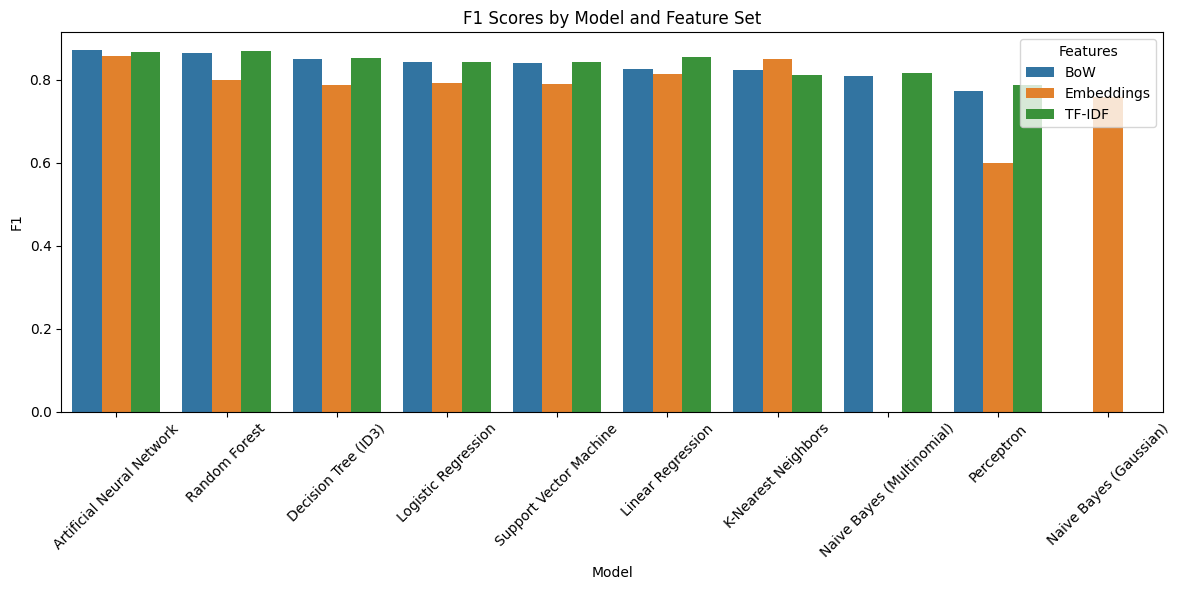

In [40]:
# load the results
loaded_results = pd.read_csv(out_path)
print("\n===== LOADED RESULTS =====")
print(loaded_results.round(4))

#analyze results
print("\n===== ANALYSIS =====")
#show f1 scores by model and feature set
for feature_name in feature_sets.keys():    
    feature_results = loaded_results[loaded_results["Features"] == feature_name]
    print(f"\n--- F1 Scores for {feature_name} ---")
    for _, row in feature_results.iterrows():
        print(f"{row['Model']}: F1 = {row['F1']:.4f}")
    #show average f1 score for the feature set
    avg_f1 = feature_results["F1"].mean()
    print(f"Average F1 for {feature_name}: {avg_f1:.4f}")
    #show top 3 models for the feature set
    top3 = feature_results.nlargest(3, "F1")
    print("Top 3 Models:")
    for _, row in top3.iterrows():
        print(f"{row['Model']}: F1 = {row['F1']:.4f}")

#show average f1 score by model across feature sets
print("\n--- Average F1 Scores by Model ---")
for model_name in loaded_results["Model"].unique():
    model_results = loaded_results[loaded_results["Model"] == model_name]
    avg_f1 = model_results["F1"].mean()
    print(f"{model_name}: Average F1 = {avg_f1:.4f}")

#identify best feature set
best_feature_set = loaded_results.groupby("Features")["F1"].mean().idxmax()
print(f"\nBest Feature Set Overall: {best_feature_set}")

#identify top 3 models and their feature sets overall
top3_overall = loaded_results.nlargest(3, "F1")
print("\nTop 3 Models Overall:")
for _, row in top3_overall.iterrows():
    print(f"{row['Model']} with {row['Features']} features, F1 = {row['F1']:.4f}")

#Graphical analysis
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.barplot(data=loaded_results, x="Model", y="F1", hue="Features")
plt.title("F1 Scores by Model and Feature Set")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()